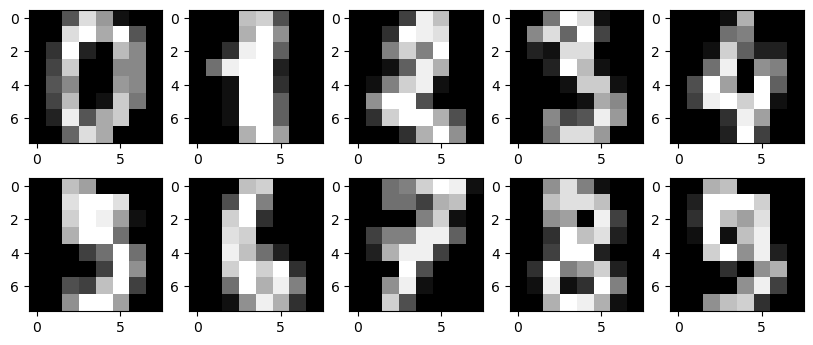

In [55]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

digits = load_digits()
X, y = digits.data, digits.target

fig, axs = plt.subplots(2, 5, figsize=(10, 4))
for lbl in np.unique(y):
    axs[lbl // 5, lbl % 5].imshow(X[y == lbl][0].reshape(8,8), cmap = 'gray')

### Stochastic Neighborhood Embedding (SNE)

We focus on point $\mathbf{x}_i$. Then we build a Gaussian distribution of distances from $\mathbf{x}_i$ with standard deviation $\sigma_i$:

$$
g(\mathbf{x}_i, \mathbf{x}) = \text{Exp}\left(\frac{-\|\mathbf{x}_i - \mathbf{x}\|_2^2}{2\sigma_i^2}  \right).
$$

Then we can compute the conditional probability that $\mathbf{x}_i$ will pick $\mathbf{x}_j$ as its neighbor as:

$$
p_{i | j} = \frac{g(\mathbf{x}_i, \mathbf{x}_j)}{\sum_{r \neq i} g(\mathbf{x}_i,\mathbf{x}_r)}.
$$

Notice that these conditional probabilities are not symmetric because $\sigma_i \neq \sigma_j$.

We seek a low-dimensional embedding of the data (in the latent space) $\{\mathbf{z}_i\}_{i=1}^p \in \mathbb{R}^k$ with the distributions using standard deviation $\sigma = \frac{1}{\sqrt{2}}$:

$$
h(\mathbf{z}_i, \mathbf{z}) = \text{Exp}\left(-\|\mathbf{z}_i - \mathbf{z}\|_2^2\right).
$$

Along with the conditional distributions for neighbor picking:

$$
q_{i | j} = \frac{h(\mathbf{z}_i, \mathbf{z}_j)}{\sum_{r \neq i} h(\mathbf{z}_i,\mathbf{z}_r)}.
$$

Define $P_i$ and $Q_i$ as the conditional probability distributions over all data points given $\mathbf{x}_i$ and $\mathbf{z}_i$, respectively. SNE seeks the low-dimensional embedding that best matches the two probability distributions using KL-divergence. Specifically, the classical SNE cost function is:

$$
C = \sum_{i=1}^n \text{KL}(P_i || Q_i) = \sum_{i=1}^n \sum_{j=1}^n p_{j|i} \log \left( \frac{p_{j|i}}{q_{j|i}} \right).
$$

SNE classically minimizes $C$ using gradient descent on the embedding vectors $\{\mathbf{z}_i\}_i$. Because this cost function is not symmetric, SNE prioritizes preserving local structures. 


The gradient of $C$ with respect to $\mathbf{z}_i$ is intuitively the force created by springs between $\mathbf{z}_i$ and all other points in the reduced space.

We compute $\sigma_i$ using *perplexity*:

$$
\text{Perp}(P_i) = 2^{H(P_i)} \quad \text{where} \quad H(P_i) = -\sum_{j=1}^p p_{j|i} \log_2 (p_{j|i}).
$$
* lower perplexity = fine detail (tight clusters)
* larger perplexity = broader context

We call $H(P_i)$ the Shannon entropy of $P_i$. Shannon entropy can be thought of as the average "surprise" inherent in a random variable’s outcomes. The Shannon entropy of $P_i$ increases as $\sigma_i$ increases. The user *fixes a perplexity* and then performs a binary search for the $\sigma_i$.
* small $\sigma_i$ = dense distribution
* large $\sigma_i$ = sparse distribution

SNE has three major problems: 
1. *Crowding problem*: Because Gaussian tails decay exponentially, moderate distances in high dimensions collapse into small neighborhoods in the low-dimensional space, which forces many points to crowd together unnaturally. 
2. Asymmetry of $g$ because $p(i|j) \neq p(j|i)$
3. KL divergence is difficult to optimize





### t-SNE (t-distributed SNE)
#### Crowding

t-SNE solves these two problems. t-SNE addresses the crowding problem by replacing the Gaussian in the latent space with a Student-t distribution. This distribution has heavy tails which give us space for placing the $\mathbf{z}_i$:

$$
h_t(\mathbf{y}_i, \mathbf{y}_j) = \left(1 + \|\mathbf{z}_i - \mathbf{z}_j \|_2^2\right)^{-1}
$$


<img src="./images/tsne_image.png" alt="isolated" width="300"/>

#### Symmetry of Probabilities

t-SNE symmetrizes the conditional probabilities by considering joint probability distributions. (Note: just doing SNE with joint probabilities is called "Symmetric SNE.") We define:

$$
p_{i, j} = \frac{p_{i| j} + p_{j|i}}{2n} \quad \text{and} \quad q_{i, j} = \frac{h_t(\mathbf{z}_i, \mathbf{z}_j)}{\sum_{r \neq l} h_t(\mathbf{z}_r,\mathbf{y}_l)}.
$$

Using this allows us to accurately model moderate distances in the latent space.

#### Optimization of KL Divergence

The gradient of SNE with respect to the latent point $\mathbf{z}_i$ is:

$$
2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})(\mathbf{z}_i - \mathbf{z}_j)
$$

The gradient for t-SNE with respect to the latent point $\mathbf{z}_i$ is:

$$
4 \sum_j (p_{ij} - q_{ij})(\mathbf{z}_i - \mathbf{z}_j)(1+\|\mathbf{z}_i - \mathbf{z}_j\|_2^2)^{-1}
$$

t-SNE strongly pushes dissimilar data points away from one another if they're modeled by small pairwise distances in the latent space. Additionally, these strong repulsions do not go to infinity like they do in SNE.

#### Comments
**Strengths:** Solves Isomap short-circuiting problem similarities between two datapoints integrates over all paths through neighborhood graph

**Weaknesses:** 
* Unclear how well it preforms with $k>3$ dimensions
* Sense to curse of intrinsic data dimensionality  ecause it fits data locally
* Non-convex optimization function


#### Parameter Tuning

**Parameters**
* Perplexity
* Learning rate (for optimizer)
* Number of iterations (for optimizer)

A link to explore the effects for tuning t-SNE parameters:
https://distill.pub/2016/misread-tsne/


#### Reference
https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7b8d01c5cc20>
Traceback (most recent call last):
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/nate/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 's

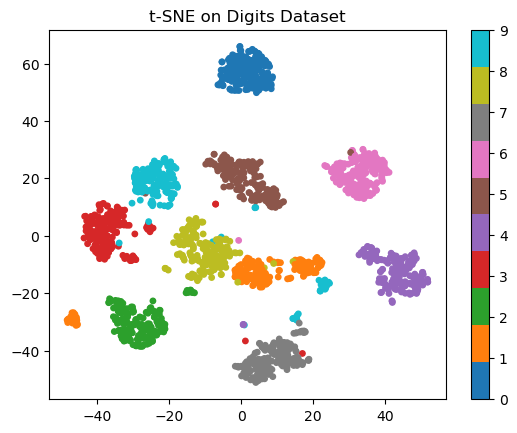

In [58]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30)
tsne_embedding = tsne.fit_transform(X)

plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], c=y, cmap='tab10', s=15)
plt.title("t-SNE on Digits Dataset")
plt.colorbar()


### UMAP (Uniform Manifold Approximation and Projection) 

UMAP is a dimensionality reduction algorithm that preserves both local and global structure of the data. 

**Assumptions**
1. There exists an underlying manifold on which the data would be uniformly distributed
2. This underlying manifold is locally connected
3. The primary goal is to preserve the topological structure of the underlying manifold

**Inputs**
Dataset $\{ \mathbf{x}_1,\dots ,\mathbf{x}_p\}$, number of nearest neighbors $n$, metric $d$, reduced dimension $k$, minimum distance

*The choice of k determines how locally we wish to estimate the Riemannian metric. A small choice of k means we want a very local interpretation which will more accurately capture fine detail structure and variation of the Riemannian metric. Choosing a large k means our estimates will be based on larger regions, and thus, while missing some of the fine detail structure, they will be more broadly accurate across the manifold as a whole, having more data to make the estimate with.*

**Algorithm**

1. **Graph-Building** (Fuzzy topological representation)

   a. $\rho_i$ as the minimium distance between $\mathbf{x}_i$ and all other points

   b. $\sigma_i$ as the solution (via binary search) to
   $$
   \sum_{j=1}^n \mathrm{exp}\left( \frac{-\max(0,d(\mathbf{x}_i,\mathbf{x}_{i_j})-\rho_i)}{\sigma_i} \right) = \log_2(n)
   $$
   c. Define a graph on data with edge weights from point $i$ to $i_j$ as
   $$
   \mathrm{exp}\left( \frac{-\max(0,d(\mathbf{x}_i,\mathbf{x}_{i_j})-\rho_i)}{\sigma_i} \right)
   $$
   This is a normalization factor defining a Riemannian metric at point $\mathbf{x}_i$.

   d. Let $\mathbf{A}$ be adjacency matrix for this graph. Then define $\mathbf{B} = \mathbf{A} + \mathbf{A}^\top - \mathbf{A} \circ \mathbf{A}^\top$ as the adjacency matrix for the UMAP graph.

*The way to think of this is that the weights are effectively the probabilities that an edge (1 simplex) exists. The combined weight is then the probability that at least one of the edges exists.*

2. **Optimizing** the low dimensional representation to have as close a fuzzy topological representation as possible as measured by cross entropy:

Initialize with spectral embedding. Then optimize with stochastic gradient descent to minimize cross entropy loss
$$ C = \sum_{e} w_h(e)\log\left(\frac{w_h(e)}{w_l(e)}\right) + \left(1-w_h(e)\right)\log\left(\frac{1-w_h(e)}{1-w_l(e)}\right) $$
First term is attractive force and second term is repulsive force.

*Note: all distances smaller than minimum distance parameter in low-dimensional space are set to 0 during optimization*

#### Key advantages of UMAP:
- Better preservation of global structure compared to t-SNE through explicit optimization of both local and global structure
- Faster computation time, especially for large datasets (O(nlog(n)) vs O(n²))
- Theoretical foundation in manifold learning and topological data analysis via category theory and fuzzy simplicial sets
- Can be used for general dimension reduction, not just visualization
- Approximately invertable https://umap-learn.readthedocs.io/en/latest/inverse_transform.html
- AlignUMAP (towards aligning embeddings for 2 related datasets) https://umap-learn.readthedocs.io/en/latest/aligned_umap_basic_usage.html

#### Parameter tuning with UMAP

**Parameters**
* Number of neighbors *balances local versus global structure in the data*
* Minimum distance: *how tightly UMAP is allowed to pack points together;* *desired separation between close points in the embedding space*
* Resource for parameter intuition https://pair-code.github.io/understanding-umap/

#### References
* https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
* https://arxiv.org/pdf/1802.03426

<!-- **Algorithm**
1. Generate a graph
 





It works by:
1. Constructing a *fuzzy* topological representation using a local:
   $$ d(x_i, x_j) = -\log_2(\frac{\text{exp}(-\|x_i - x_j\|_2^2/\sigma_i)}{\sum_{k \neq i}\text{exp}(-\|x_i - x_k\|_2^2/\sigma_i)}) $$
2. Finding a low-dimensional projection that minimizes the cross-entropy between high and low-dimensional fuzzy simplicial sets with cross entropy
   $$ C = \sum_{e} w_h(e)\log(\frac{w_h(e)}{w_l(e)}) + (1-w_h(e))\log(\frac{1-w_h(e)}{1-w_l(e)}) $$
   First term is attractive force and second term is repulsive force.
3. Optimizing this projection using stochastic gradient descent




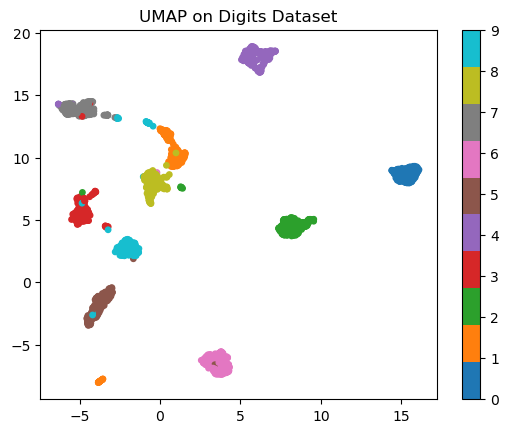

In [59]:
import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1)
umap_embedding = reducer.fit_transform(X)

plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], c=y, cmap='tab10', s=15)
plt.title("UMAP on Digits Dataset")
plt.colorbar()



#### UMAP vs t-SNE

https://aicompetence.org/comparing-t-sne-and-umap/

### Persistent Homology

Persistent Homology is a mathematical tool from topological data analysis that helps understand the shape and structure of data across different scales. It tracks how topological features (like connected components, holes, voids) appear and disappear as we analyze the data at different resolutions. This provides a multi-scale view of the data's geometric features that persist across scales, helping distinguish meaningful structure from noise.

Mathematically, persistent homology studies the homology groups $H_k(X_\epsilon)$ of a filtration of simplicial complexes $X_\epsilon$ indexed by a scale parameter $\epsilon$. The persistence diagram tracks birth ($b$) and death ($d$) times of k-dimensional holes:

$$ \text{Dgm}_k(X) = \{(b,d) \in \mathbb{R}^2 : b < d\} $$

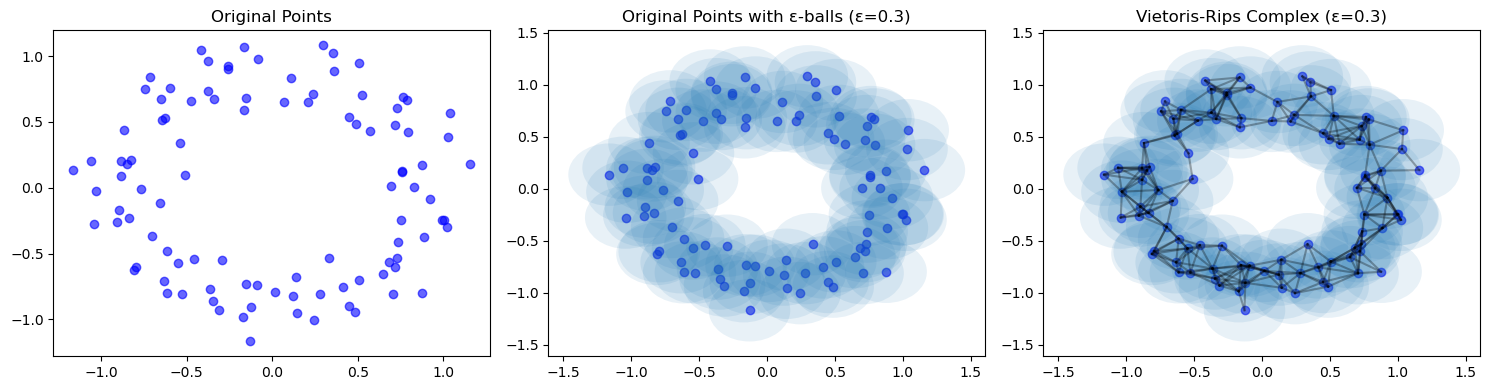

Number of points (0-simplices): 100
Number of edges (1-simplices): 331


In [60]:
# Create a simple 2D dataset and compute Vietoris-Rips complex
from sklearn.datasets import make_circles
from scipy.spatial.distance import pdist, squareform

# Choose epsilon for Vietoris-Rips complex
epsilon = .3

# Generate the moon-shaped data
X_circles, _ = make_circles(n_samples=100, noise=0.1, random_state=42)

# Create a figure with two subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot the original points
ax1.scatter(X_circles[:, 0], X_circles[:, 1], c='blue', alpha=0.6)
ax1.set_title('Original Points')

# Plot the original points
ax2.scatter(X_circles[:, 0], X_circles[:, 1], c='blue', alpha=0.6)
# Plot epsilon balls around each point
for x, y in X_circles:
    circle = plt.Circle((x, y), epsilon, fill=True, alpha=0.1)
    ax2.add_patch(circle)
ax2.set_title(f'Original Points with ε-balls (ε={epsilon})')

# Compute pairwise distances
distances = squareform(pdist(X_circles))

# Find edges (1-simplices) where points are within epsilon distance
edges = np.where(distances <= epsilon)
edges = np.array([[edges[0][i], edges[1][i]] for i in range(len(edges[0])) if edges[0][i] < edges[1][i]])

# Plot Vietoris-Rips complex
ax3.scatter(X_circles[:, 0], X_circles[:, 1], c='blue', alpha=0.6)
for x, y in X_circles:
    circle = plt.Circle((x, y), epsilon, fill=True, alpha=0.1)
    ax3.add_patch(circle)
for edge in edges:
    ax3.plot(X_circles[edge, 0], X_circles[edge, 1], 'k-', alpha=0.3)
ax3.set_title(f'Vietoris-Rips Complex (ε={epsilon})')

plt.tight_layout()
plt.show()

# Print information about the complex
print(f"Number of points (0-simplices): {len(X_circles)}")
print(f"Number of edges (1-simplices): {len(edges)}")


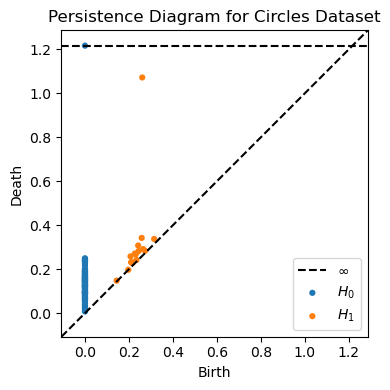

In [61]:
# Compute the Vietoris-Rips complex and persistence diagrams using our digits dataset X
from ripser import ripser
from persim import plot_diagrams

# Calculate persistent homology
# Note: Using full X dataset since it's already the digits dataset we loaded
diagrams = ripser(X_circles, maxdim=1)['dgms']

# Plot the persistence diagrams
plt.figure(figsize=(12, 4))

plot_diagrams(diagrams, show=False)
plt.title("Persistence Diagram for Circles Dataset")

plt.tight_layout()
plt.show()




### Mapper

DR with Topological Data Analysis (persistent homology)

* Paper: https://research.math.osu.edu/tgda/mapperPBG.pdf
* Code: https://github.com/lucasimi/tda-mapper-python
* Demo: https://tda-mapper-app.streamlit.app/